In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

pd.set_option('display.width', 1000)      # total width in characters
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import os
import zipfile

os.makedirs('outputs/figures', exist_ok=True)
os.makedirs('outputs/tables', exist_ok=True)

# Section 1 - Basic Data Cleaning (Floats and Missing Horsepower)

In [2]:
auto = pd.read_csv('Auto.csv')
auto['origin'] = auto['origin'].astype('object')
print(auto.dtypes)

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
year              int64
origin           object
name             object
dtype: object


In [3]:
pd.DataFrame(auto.isna().sum()).T #counts the number of missing values in each column, puts into a dataframe, then finds transpose

#0 means no missing values in that column

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,0,0,0,0,0,0,0,0,0


In [4]:
print(auto.dtypes) #describes the datatypes for each column

auto['weight'] = auto['weight'].astype('float64') #weight is determined to be int64, but easier to work with if it is a float64

# Show the unique non-numeric entries
hp_str = auto['horsepower'].astype(str) #parse horsepower column as strings
hp_clean = hp_str.str.replace('.', '',1) #replace the first '.' with a '', turning potential floats into integers
is_numeric = hp_clean.str.isnumeric() #find the entries that are ints.  Does not work well with floats
mask_non_numeric = ~is_numeric #"mask" (i.e. invert) the non-numeric rows
non_numeric_hp = auto[mask_non_numeric] #keep the non-numeric rows for horsepower in auto
print(non_numeric_hp['horsepower'].unique())

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
year              int64
origin           object
name             object
dtype: object
['?']


We conclude here that using isna will not find the missing values.  Using dtypes, we find that horsepower says object where float64 or int64 is expected, so there are non-numerical entries in horsepower.  We check to see what kinds of non-numerical entries come up, and it turns out that question mark is used to denote missing values for horsepower.

Note:  For other numerical inputs, we might want to watch out for minus signs -, alternate decimal points like comma, or scientific notation through e or E.

In [5]:
missingHorse = auto[auto['horsepower'] == '?']
print(missingHorse)
auto = auto[auto['horsepower'] != '?']
auto['horsepower']= auto['horsepower'].astype(float) #need to recast to get the correct dtypes.  This will throw an error if non-numerical values are present.
print(auto.dtypes)

      mpg  cylinders  displacement horsepower  weight  acceleration  year origin                  name
32   25.0          4          98.0          ?  2046.0          19.0    71      1            ford pinto
126  21.0          6         200.0          ?  2875.0          17.0    74      1         ford maverick
330  40.9          4          85.0          ?  1835.0          17.3    80      2  renault lecar deluxe
336  23.6          4         140.0          ?  2905.0          14.3    80      1    ford mustang cobra
354  34.5          4         100.0          ?  2320.0          15.8    81      2           renault 18i
mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
year              int64
origin           object
name             object
dtype: object


# Section 2 - EDA

In [6]:
auto.index.name = "Auto"

quant_cols = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year']
ranges = auto[quant_cols].max() - auto[quant_cols].min() #using pandas instead of numpy here
means = auto[quant_cols].mean()
stds = auto[quant_cols].std()
print(ranges)
print(means)
print(stds)

#Origin and name are qualitative predictors

mpg               37.6
cylinders          5.0
displacement     387.0
horsepower       184.0
weight          3527.0
acceleration      16.8
year              12.0
dtype: float64
mpg               23.445918
cylinders          5.471939
displacement     194.411990
horsepower       104.469388
weight          2977.584184
acceleration      15.541327
year              75.979592
dtype: float64
mpg               7.805007
cylinders         1.705783
displacement    104.644004
horsepower       38.491160
weight          849.402560
acceleration      2.758864
year              3.683737
dtype: float64


In [7]:
auto10to85 = auto.loc[10:85] #take records of auto indexed from 10 to 85
ranges10to85 = auto10to85[quant_cols].max() - auto10to85[quant_cols].min()
means10to85 = auto10to85[quant_cols].mean()
stds10to85 = auto10to85[quant_cols].std()
print(ranges10to85)
print(means10to85)
print(stds10to85)

mpg               26.0
cylinders          5.0
displacement     385.0
horsepower       179.0
weight          3527.0
acceleration      15.5
year               3.0
dtype: float64
mpg               19.520000
cylinders          5.853333
displacement     222.020000
horsepower       119.120000
weight          3141.280000
acceleration      14.853333
year              71.146667
dtype: float64
mpg               6.156429
cylinders         1.857733
displacement    118.558471
horsepower       44.989176
weight          982.598383
acceleration      2.834123
year              0.816938
dtype: float64


              mpg  cylinders  displacement  horsepower  weight  acceleration  year
mpg           NaN      -0.78         -0.81       -0.78   -0.83          0.42  0.58
cylinders     NaN        NaN          0.95        0.84    0.90         -0.50 -0.35
displacement  NaN        NaN           NaN        0.90    0.93         -0.54 -0.37
horsepower    NaN        NaN           NaN         NaN    0.86         -0.69 -0.42
weight        NaN        NaN           NaN         NaN     NaN         -0.42 -0.31
acceleration  NaN        NaN           NaN         NaN     NaN           NaN  0.29
year          NaN        NaN           NaN         NaN     NaN           NaN   NaN


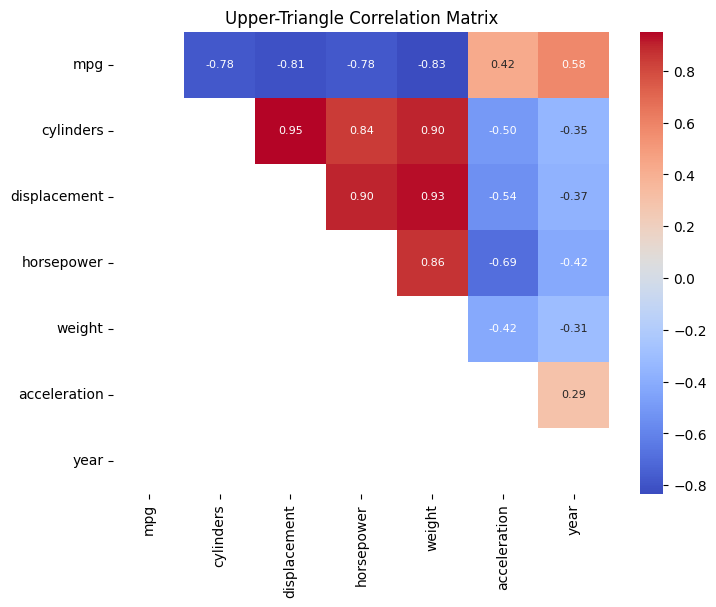

In [8]:
corr_matrix = auto[quant_cols].corr()

# Create a mask for the lower triangle
mask = np.tril(np.ones_like(corr_matrix, dtype=bool))

# Apply the mask: set lower triangle to NaN
upper_tri = corr_matrix.mask(mask)
print(upper_tri.round(2))

fig, ax = plt.subplots(figsize=(8,6))

# Plot heatmap on this figure/axes
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f",
            cmap="coolwarm", annot_kws={"size": 8}, ax=ax)

ax.set_title("Upper-Triangle Correlation Matrix")

# Save the figure
fig.savefig('heatmapQuant.png', dpi=300)
plt.show()
plt.close(fig)



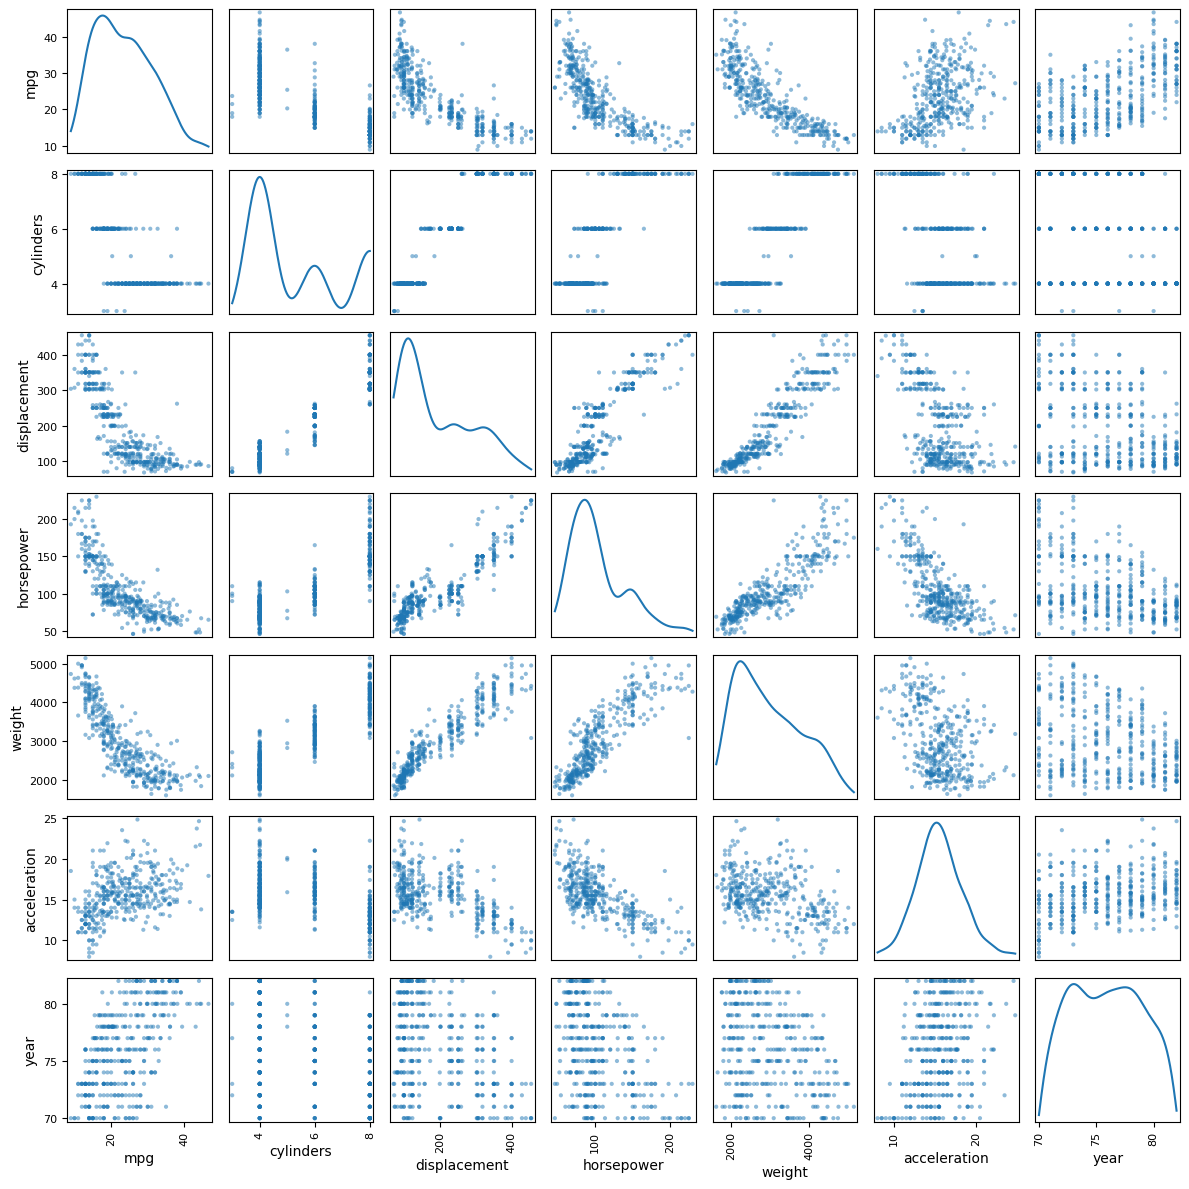

In [9]:
axes = pd.plotting.scatter_matrix(auto[quant_cols], figsize=(12,12), diagonal='kde')

fig = axes[0,0].get_figure()
plt.tight_layout()

# Save the figure
fig.savefig('outputs/figures/scatter_matrix.png', dpi=300)

# Display and close the figure
plt.show()
plt.close(fig)

When the qualitative predictor of Origin is removed, we can compute the pairwise correlation coefficients and scatter plots for the remaining quantitative variables.  From the heat map, we can see there is a non-negligible amount of correlation between any pair of variables, even if some scatters (especially with year involved) look soft.  Of course, mpg and acceleration are positively correlated with each other but negatively correlated with speed-maximizing properties like number of cylinders, displacement, and horsepower.  We can see that as the year increases (time goes forward), it becomes more popular for cars to favor mpg and acceleration over number of cylinders, displacement, and horsepower.

Also, note many of these quantitative variables (cylinders, displacement, year) do not follow a normal distribution even with a large number of records.

In [10]:
qual_cols = ['origin','name']
auto_qual = auto[qual_cols]
print(auto_qual)

     origin                                  name
Auto                                             
0         1             chevrolet chevelle malibu
1         1                     buick skylark 320
2         1                    plymouth satellite
3         1                         amc rebel sst
4         1                           ford torino
5         1                      ford galaxie 500
6         1                      chevrolet impala
7         1                     plymouth fury iii
8         1                      pontiac catalina
9         1                    amc ambassador dpl
10        1                   dodge challenger se
11        1                    plymouth 'cuda 340
12        1                 chevrolet monte carlo
13        1               buick estate wagon (sw)
14        3                 toyota corona mark ii
15        1                       plymouth duster
16        1                            amc hornet
17        1                         ford maverick


By comparing origin to names, it is evident that origin of 1 corresponds to cars made in the United States, 2 to cars made in Europe, and 3 to cars made in Japan.  Also, the names appear to be unique, so this dataset is intended to provide the statistics of each type of car.  However this must be checked!

In [11]:
num_unique_names = auto['name'].nunique() #counts the Number of Unique objects in auto['name']
total_names = len(auto['name']) #counts the number of records
print(f"Unique names: {num_unique_names} / {total_names}") #report the unique versus total

duplicates = auto['name'][auto['name'].duplicated()] #auto['name'].duplicates() gets the list of all nonunique names.  Calling it in auto['name'] will list the duplicates
print(duplicates)

Unique names: 301 / 392
Auto
29                          datsun pl510
33                           amc gremlin
35             chevrolet chevelle malibu
38                      chevrolet impala
40                      ford galaxie 500
41                     plymouth fury iii
62                      chevrolet impala
63                      pontiac catalina
64                     plymouth fury iii
65                      ford galaxie 500
86                           amc matador
99                            amc hornet
100                        ford maverick
101                      plymouth duster
103                     chevrolet impala
107                          amc gremlin
109                       chevrolet vega
125                      plymouth duster
127                           amc hornet
130                           ford pinto
131                  toyota corolla 1200
132                       chevrolet vega
134                          amc matador
136                     ford

In [12]:
duplicates_mask = auto['name'].duplicated(keep=False) #.duplicated(keep = False) marks all record occurrences of a duplicate as True
duplicate_name_rows = auto[duplicates_mask] #retain only the records that are duplicated

duplicate_name_rows_sorted = duplicate_name_rows.sort_values(by=['name', 'year']) #sort the named rows by name, then by year

print(duplicate_name_rows_sorted)

       mpg  cylinders  displacement  horsepower  weight  acceleration  year origin                               name
Auto                                                                                                                 
257   19.4          6         232.0        90.0  3210.0          17.2    78      1                        amc concord
315   24.3          4         151.0        90.0  3003.0          20.1    80      1                        amc concord
24    21.0          6         199.0        90.0  2648.0          15.0    70      1                        amc gremlin
33    19.0          6         232.0       100.0  2634.0          13.0    71      1                        amc gremlin
107   18.0          6         232.0       100.0  2789.0          15.0    73      1                        amc gremlin
169   20.0          6         232.0       100.0  2914.0          16.0    75      1                        amc gremlin
16    18.0          6         199.0        97.0  2774.0 

In [13]:
names = auto['name']
names_split = names.str.split() #computes the list of words separated by spaces and puts into an array
company_names = names_split.str[0] #take only the first entry
auto['company'] = company_names

auto['name_year'] = auto['name'] + '_' + auto['year'].astype(str) #put string together, remembering to convert year to a string

print(auto[['name', 'company', 'year', 'name_year']].head()) #put the columns together to check

                           name    company  year                     name_year
Auto                                                                          
0     chevrolet chevelle malibu  chevrolet    70  chevrolet chevelle malibu_70
1             buick skylark 320      buick    70          buick skylark 320_70
2            plymouth satellite   plymouth    70         plymouth satellite_70
3                 amc rebel sst        amc    70              amc rebel sst_70
4                   ford torino       ford    70                ford torino_70


In [14]:
#auto['name_year_unique'] = auto['name_year'] #make a copy of the column for modification, redundant

name_year_original = auto['name_year']
occurrence_count = auto.groupby('name_year').cumcount() #group by values in name_year.  .cumcount() counts the row's position within the group
occurrence_str = occurrence_count.astype(str) #convert that count to a string
occurrence_tag = '_' + occurrence_str #make a new suffix to put at the end of name_year
name_year_unique = name_year_original + occurrence_tag #attach the suffix to the name_year
auto['name_year_unique'] = name_year_unique

In [15]:
duplicates_mask = auto['name_year'].duplicated(keep=False) #.duplicated(keep = False) marks all record occurrences of a duplicate as True
duplicate_name_rows = auto[duplicates_mask] #retain only the records that are duplicated

duplicate_name_rows_sorted = duplicate_name_rows.sort_values(by=['name', 'year']) #sort the named rows by name, then by year

print(duplicate_name_rows_sorted)

       mpg  cylinders  displacement  horsepower  weight  acceleration  year origin              name   company            name_year       name_year_unique
Auto                                                                                                                                                      
168   23.0          4         140.0        83.0  2639.0          17.0    75      1        ford pinto      ford        ford pinto_75        ford pinto_75_0
174   18.0          6         171.0        97.0  2984.0          14.5    75      1        ford pinto      ford        ford pinto_75        ford pinto_75_1
338   27.2          4         135.0        84.0  2490.0          15.7    81      1  plymouth reliant  plymouth  plymouth reliant_81  plymouth reliant_81_0
342   30.0          4         135.0        84.0  2385.0          12.9    81      1  plymouth reliant  plymouth  plymouth reliant_81  plymouth reliant_81_1


In [16]:
#corrected spellings of companies
auto.loc[auto['company'] == 'vw', 'company'] = 'volkswagen'
auto.loc[auto['company'] == 'vokswagen', 'company'] = 'volkswagen'
auto.loc[auto['company'] == 'toyouta','company'] = 'toyota'
auto.loc[auto['company'] == 'chevroelt','company'] = 'chevrolet'
auto.loc[auto['company'] == 'chevy', 'company'] = 'chevrolet'
auto.loc[auto['company'] == 'maxda','company'] = 'mazda'
auto.loc[auto['company'] == 'mercedes-benz','company'] = 'mercedes'

At this point, duplicated names are removed and expanded to include unique identifiers, often by year.  Note there are two names, ford pinto and plymouth reliant, that have two entries for a single year yet are two different cars.  So an additional second tag was added to all name_year entries using groupby.

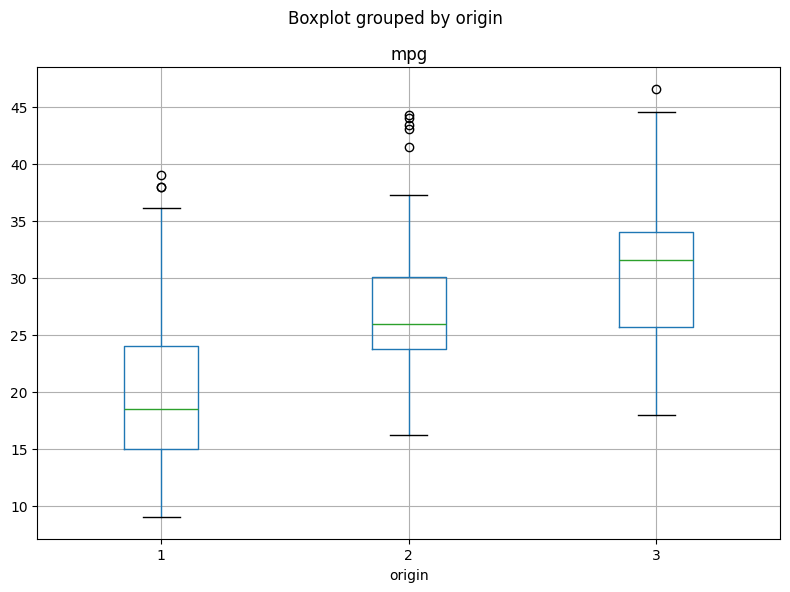

In [17]:
fig, ax = plt.subplots(figsize=(8,6))

auto.boxplot(column='mpg', by='origin', ax=ax)
plt.tight_layout()

# Save the figure
fig.savefig('outputs/figures/boxplotOrigin.png', dpi=300)

# Display and close
plt.show()
plt.close(fig)

<Axes: title={'center': 'mpg'}, xlabel='company'>

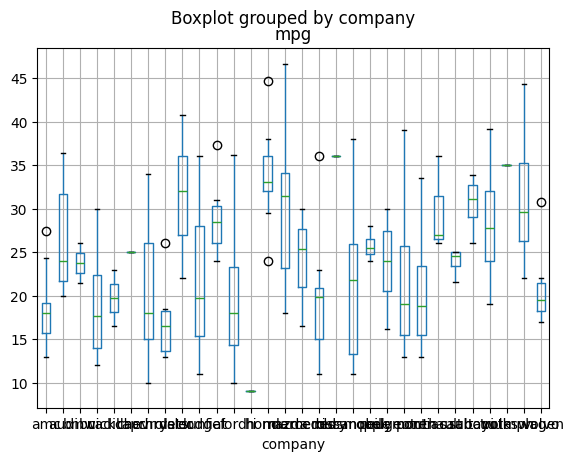

In [18]:
auto.boxplot(column = 'mpg', by = 'company')

/tmp/ipython-input-681761885.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=70)


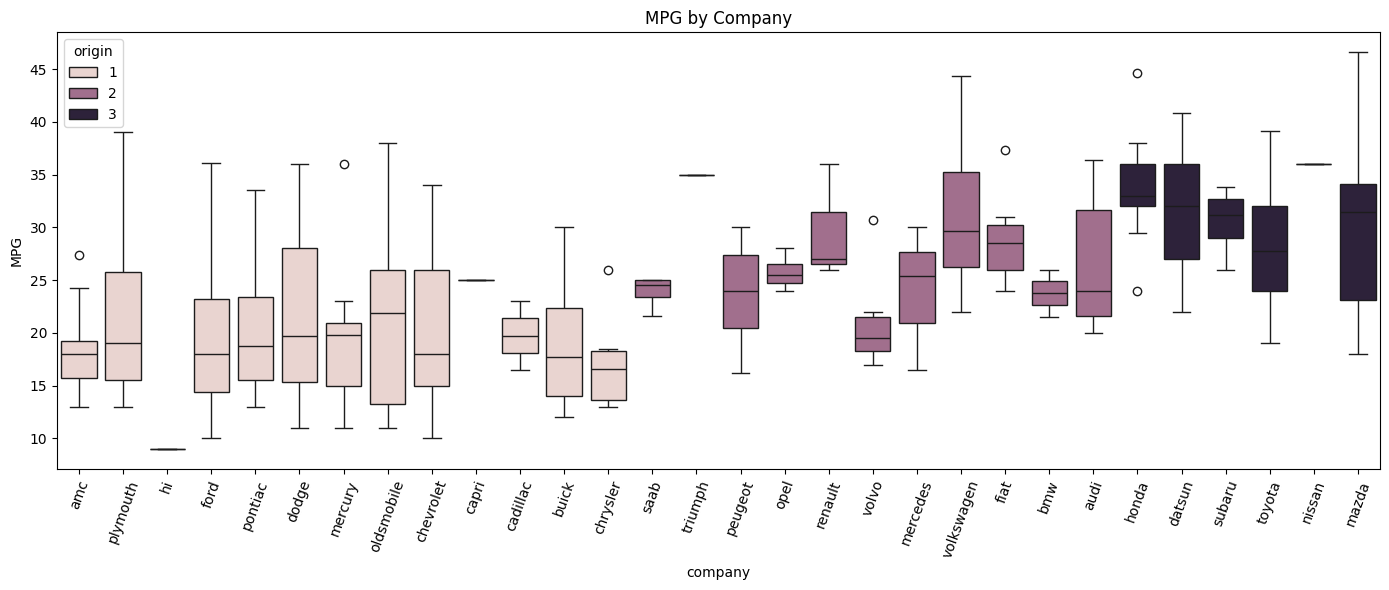

In [19]:
grouped = auto.groupby('company') #groups records by company
first_origin = grouped['origin'].first() #for each company, get the first origin value
sorted_origin = first_origin.sort_values() #sort the companies by first_origin
company_order = sorted_origin.index #get the ordered list of company names


fig, ax = plt.subplots(figsize=(14,6))
sns.boxplot(x='company', y='mpg', data=auto, order=company_order, hue='origin', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70)
ax.set_title('MPG by Company')
ax.set_ylabel('MPG')
plt.tight_layout()


fig.savefig('outputs/figures/boxplotCompany.png', dpi=300)
plt.show()
plt.close(fig)

We now show boxplots for mpg in qualitative categories.  The first sorting is by origin, where it is evident that cars with origin 1 (American) have lower mpg compared to origin 2 or origin 3.  For a higher-variation view, we can break the names down by company, where we see origin 1 companies still in general have lower mpg across categories, even though there is more variation.

Statistical aside:  Though there is no evident Simpson's paradox here, we should be mindful of it when de-aggregating like this.

# Section 3 - Predicting mpg by Origin (quantitative variables only)

In [20]:

auto_quant = auto.drop(columns = ['name', 'company', 'name_year', 'name_year_unique'])
auto_quant['cylinders'] = auto_quant['cylinders'].astype('float64')
auto1_quant = auto_quant[auto_quant['origin'] == 1].drop(columns = ['origin'])
auto2_quant = auto_quant[auto_quant['origin'] == 2].drop(columns = ['origin'])
auto3_quant = auto_quant[auto_quant['origin'] == 3].drop(columns = ['origin'])
print(auto1_quant.head())

scaler = StandardScaler()
auto1_quant_scaled = pd.DataFrame(scaler.fit_transform(auto1_quant), columns=auto1_quant.columns)
auto2_quant_scaled = pd.DataFrame(scaler.fit_transform(auto2_quant), columns=auto2_quant.columns)
auto3_quant_scaled = pd.DataFrame(scaler.fit_transform(auto3_quant), columns=auto3_quant.columns)


       mpg  cylinders  displacement  horsepower  weight  acceleration  year
Auto                                                                       
0     18.0        8.0         307.0       130.0  3504.0          12.0    70
1     15.0        8.0         350.0       165.0  3693.0          11.5    70
2     18.0        8.0         318.0       150.0  3436.0          11.0    70
3     16.0        8.0         304.0       150.0  3433.0          12.0    70
4     17.0        8.0         302.0       140.0  3449.0          10.5    70


In [21]:
y1 = auto1_quant_scaled['mpg']
y2 = auto2_quant_scaled['mpg']
y3 = auto3_quant_scaled['mpg']

X1 = auto1_quant_scaled.drop(columns = ['mpg'])
X2 = auto2_quant_scaled.drop(columns = ['mpg'])
X3 = auto3_quant_scaled.drop(columns = ['mpg'])

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

model = LinearRegression()
resultsErr = []

model.fit(X1_train, y1_train)
coef_auto1 = pd.DataFrame({'Feature': X1.columns, 'Coefficient1': model.coef_})
resultsErr.append({
    'Model': 'Auto 1',
    'R^2': model.score(X1_test, y1_test),
    'RMSE': np.sqrt(mean_squared_error(y1_test, model.predict(X1_test)))
})
importances1 = pd.DataFrame({'Feature': X1.columns, 'Coefficient1': model.coef_})

model.fit(X2_train, y2_train)
coef_auto2 = pd.DataFrame({'Feature': X2.columns, 'Coefficient2': model.coef_})
resultsErr.append({
    'Model': 'Auto 2',
    'R^2': model.score(X2_test, y2_test),
    'RMSE': np.sqrt(mean_squared_error(y2_test, model.predict(X2_test)))
})
importances2 = pd.DataFrame({'Feature': X2.columns, 'Coefficient2': model.coef_})

model.fit(X3_train, y3_train)
coef_auto3 = pd.DataFrame({'Feature': X3.columns, 'Coefficient3': model.coef_})
resultsErr.append({
    'Model': 'Auto 3',
    'R^2': model.score(X3_test, y3_test),
    'RMSE': np.sqrt(mean_squared_error(y3_test, model.predict(X3_test)))
})
importances3 = pd.DataFrame({'Feature': X3.columns, 'Coefficient3': model.coef_})

importances = pd.merge(importances1, importances2, on='Feature', how='outer')
importances = pd.merge(importances, importances3, on='Feature', how='outer')

metrics_df = pd.DataFrame(resultsErr)
metrics_df2 = pd.DataFrame(importances)

from IPython.display import display
display(metrics_df)
display(metrics_df2)

tables = {
    'metrics_df': metrics_df,
    'metrics_df2': metrics_df2,
}

metrics_df.to_csv('OLSErr.csv', index=False)
metrics_df2.to_csv('OLSImportances.csv', index=False)

,Model,R^2,RMSE
0,Auto 1,0.869558,0.360961
1,Auto 2,0.445587,0.731641
2,Auto 3,0.536049,0.653341


,Feature,Coefficient1,Coefficient2,Coefficient3
0,acceleration,-0.171450,0.180449,0.003767
1,cylinders,-0.207985,0.068738,0.282034
2,displacement,-0.187472,-0.300082,-0.014614
3,horsepower,-0.023727,-0.238432,-0.346436
4,weight,-0.409721,-0.281077,-0.326651
5,year,0.338362,0.579685,0.490152


Under OLS, the R^2 is highest and RMSE is lowest for origin 1 (American) cars because a linear model works better.  This is probably due to homogeneity and predictability by weight, horsepower, and displacement.  Errors are much larger for origin 2 and origin 3 because of more diverse philosophies on design and efficiency that may not be captured as well with a linear model.

For all three regions, the strongest predictors of mpg are weight and year.  Weight may be positively correlated with other properties like engine size (displacement) and horsepower, which are all negatively correlated with mpg, so weight is highly predictive.  This shows more strongly in American cars though.  Positive correlation between year and mpg shows technology shifts over time for all three regions.

Acceleration shows different signs for each region, although the importances are smaller.  There may be different undercurrents at play.  In Europe, it may be that faster acceleration is obtained through smaller engines.  In Japan, this effect may be compromised, indicated by near 0 correlation.

In [22]:
y1 = auto1_quant_scaled['mpg']
y2 = auto2_quant_scaled['mpg']
y3 = auto3_quant_scaled['mpg']

X1 = auto1_quant_scaled.drop(columns = ['mpg'])
X2 = auto2_quant_scaled.drop(columns = ['mpg'])
X3 = auto3_quant_scaled.drop(columns = ['mpg'])

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

model = Lasso(alpha = 0.2)
resultsErr = []

model.fit(X1_train, y1_train)
coef_auto1 = pd.DataFrame({'Feature': X1.columns, 'Coefficient1': model.coef_})
resultsErr.append({
    'Model': 'Auto 1',
    'R^2': model.score(X1_test, y1_test),
    'RMSE': np.sqrt(mean_squared_error(y1_test, model.predict(X1_test)))
})
importances1 = pd.DataFrame({'Feature': X1.columns, 'Coefficient1': model.coef_})

model.fit(X2_train, y2_train)
coef_auto2 = pd.DataFrame({'Feature': X2.columns, 'Coefficient2': model.coef_})
resultsErr.append({
    'Model': 'Auto 2',
    'R^2': model.score(X2_test, y2_test),
    'RMSE': np.sqrt(mean_squared_error(y2_test, model.predict(X2_test)))
})
importances2 = pd.DataFrame({'Feature': X2.columns, 'Coefficient2': model.coef_})

model.fit(X3_train, y3_train)
coef_auto3 = pd.DataFrame({'Feature': X3.columns, 'Coefficient3': model.coef_})
resultsErr.append({
    'Model': 'Auto 3',
    'R^2': model.score(X3_test, y3_test),
    'RMSE': np.sqrt(mean_squared_error(y3_test, model.predict(X3_test)))
})
importances3 = pd.DataFrame({'Feature': X3.columns, 'Coefficient3': model.coef_})

importances = pd.merge(importances1, importances2, on='Feature', how='outer')
importances = pd.merge(importances, importances3, on='Feature', how='outer')

metrics_df = pd.DataFrame(resultsErr)
metrics_df2 = pd.DataFrame(importances)

from IPython.display import display
display(metrics_df)
display(metrics_df2)

tables = {
    'metrics_df': metrics_df,
    'metrics_df2': metrics_df2,
}

metrics_df.to_csv('LassoErr.csv', index=False)
metrics_df2.to_csv('LassoImportances.csv', index=False)

,Model,R^2,RMSE
0,Auto 1,0.766931,0.482497
1,Auto 2,0.532016,0.672198
2,Auto 3,0.574940,0.625359


,Feature,Coefficient1,Coefficient2,Coefficient3
0,acceleration,0.000000,0.000000,0.000000
1,cylinders,-0.122460,-0.000000,0.000000
2,displacement,-0.053481,-0.000000,-0.000000
3,horsepower,-0.000000,-0.371187,-0.392636
4,weight,-0.408138,-0.163562,-0.000000
5,year,0.191246,0.309656,0.287869


Under OLS, acceleration is more or less predictive of mpg depending on the origin, and this signal is softer than that of other variables.  There is a great degree of multicollinearity here, so Lasso must be run at alpha = 0.2 to observe sparsity.  There, acceleration does not appear as an important feature.  In general, year (amount of modernization) is positively correlated with mpg, and high-horsepower qualities including cylinders, displacement, and weight are negatively correlated with mpg.

The R^2 drops compared to OLS for the U.S. as some bias is added to the model in exchange for reducing the variance.  There is an apparent (though unexpected) opposite effect for European and Japanese cars, though this may be because of inherent existing instability in those models.

# Section 4 - Random Forest (Using Qualitative Variables)

              mpg  cylinders  displacement  horsepower  weight  acceleration  year  origin_1  origin_2  origin_3
mpg           NaN      -0.78         -0.81       -0.78   -0.83          0.42  0.58     -0.57      0.24      0.45
cylinders     NaN        NaN          0.95        0.84    0.90         -0.50 -0.35      0.61     -0.35     -0.40
displacement  NaN        NaN           NaN        0.90    0.93         -0.54 -0.37      0.66     -0.37     -0.44
horsepower    NaN        NaN           NaN         NaN    0.86         -0.69 -0.42      0.49     -0.28     -0.32
weight        NaN        NaN           NaN         NaN     NaN         -0.42 -0.31      0.60     -0.29     -0.45
acceleration  NaN        NaN           NaN         NaN     NaN           NaN  0.29     -0.26      0.21      0.12
year          NaN        NaN           NaN         NaN     NaN           NaN   NaN     -0.14     -0.04      0.20
origin_1      NaN        NaN           NaN         NaN     NaN           NaN   NaN       NaN    

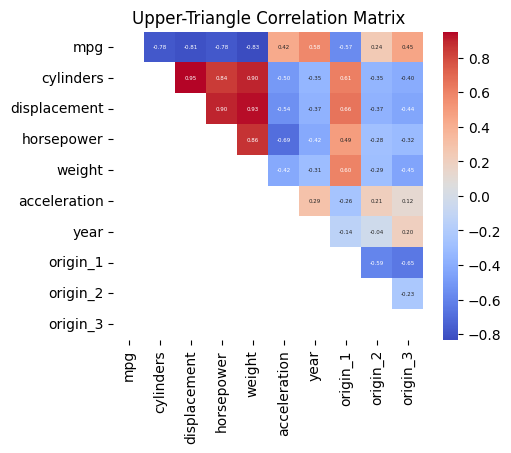

In [23]:
rf_columns = ['mpg','cylinders','displacement','horsepower','weight','acceleration','year']
OneHotOrigin = pd.get_dummies(auto['origin'], prefix = 'origin', dtype = 'int')
auto_rf = pd.merge(auto[rf_columns], OneHotOrigin, left_index = True, right_index = True)

corr_matrix = auto_rf.corr()

# Create a mask for the lower triangle
mask = np.tril(np.ones_like(corr_matrix, dtype=bool))

# Apply the mask: set lower triangle to NaN
upper_tri = corr_matrix.mask(mask)
print(upper_tri.round(2))

plt.figure(figsize=(5,4))
#annot_kws changes the font size of the annotations
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", annot_kws={"size": 4})
plt.title("Upper-Triangle Correlation Matrix")
plt.show()

In [24]:
#prepare X and y such that y is mpg and X consists of the scaled numerical entries and the one-hot encoded origin variable

X = auto_rf.drop(columns = ['mpg'])
y = auto_rf['mpg']





X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, max_depth = None, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

feat_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})

print("Random Forest Feature Importances:\n", feat_importances)
print("\nR^2:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Std of mpg:", auto['mpg'].std())

metrics_df2 = pd.DataFrame(feat_importances)

from IPython.display import display
display(metrics_df2)

metrics_df2.to_csv('RFImportances.csv', index=False)

Random Forest Feature Importances:
         Feature  Importance
0     cylinders    0.137144
1  displacement    0.416408
2    horsepower    0.168670
3        weight    0.143255
4  acceleration    0.024096
5          year    0.104263
6      origin_1    0.001526
7      origin_2    0.002179
8      origin_3    0.002458

R^2: 0.8870080639683751
RMSE: 2.4014941841394695
Std of mpg: 7.805007486571799


,Feature,Importance
0,cylinders,0.137144
1,displacement,0.416408
2,horsepower,0.168670
3,weight,0.143255
4,acceleration,0.024096
5,year,0.104263
6,origin_1,0.001526
7,origin_2,0.002179
8,origin_3,0.002458


Now we consider the effect of origin on the prediction.  Origin is a ternary categorical variable, and scikit-learn requires these variables to be converted into a one-hot encoding.  That is, turn a single ternary variable into three binary variables.  The resulting model has a high R^2 and a relatively slow RMSE compared to the standard deviation of the target mpg, so the random forest seems to perform better than either the OLS or Lasso used before.  It turns out all values of origin have very low importances, suggesting specific car properties will be more predictive of mpg.